## Food Establishments
“This set locates establishments under the responsibility of the Food Inspection Division 
of the City of Montreal. It should be noted that the City is mandated by the Ministère de l'Agriculture, 
des Pêcheries et de l'Alimentation du Québec (MAPAQ) with respect to inspections on its territory.” 

The data is provided as shape, csv and geojson. For the analysis the shape data is used. 

### Steps that are taken
- Load language translation data and categories for food establishments types
- Load the shapefile containing business data and perform some analysis on the data

### Data source
- https://donnees.montreal.ca/dataset/etablissements-alimentaires
- Source: City of Montréal
- Accessed: 12.11.2023

In [1]:
# Import necessary libraries for geospatial, data manipulation, visualization, and clustering
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans

# Suppress warnings for better readability of the output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Ensure the "Figures" directory exists
output_folder = "Figures"
os.makedirs(output_folder, exist_ok=True)

In [3]:
# print("Current working directory:", os.getcwd())

In [4]:
# Define the folder path (you can use an absolute or relative path)
folder_path = "/home/jovyan/work/Data/"

# Set the environment variable, for example 'MY_FOLDER'
os.environ["Data_folder"] = folder_path

# You can verify it's set by printing it
print("Environment variable Data_folder is set to:", os.environ["Data_folder"])

Environment variable Data_folder is set to: /home/jovyan/work/Data/


In [5]:
# Get the folder path from the environment variable
folder_path = os.environ.get("Data_folder")
if not folder_path:
    raise ValueError("The environment variable Data_folder is not set.")

In [6]:
# Load language translation data and categories for food establishments types
# You can change the categories of the buisnesses by editting the Excel file
file_path = os.path.join(folder_path, "Food_establishments/Buisnesses_types_frensch_english_german.xlsx")
food_establishments_language = pd.read_excel(file_path)

# Drop not needed cloumns
food_establishments_language.drop(['German','Notes', 'Link'], axis=1, inplace=True)

# Display the first few rows of the dataframe food_establishments to understand its structure.
food_establishments_language.head(5)

,French,English,healthy_food_store,supermarket,fast_food_outlet,restaurant,out_of_home_catering,other
0,Distributrice automatique,Automatic vending machine,NaN,NaN,NaN,NaN,NaN,1.0
1,Épicerie avec préparation,Grocery with preparation,NaN,1.0,NaN,NaN,NaN,NaN
2,Restaurant,Restaurant,NaN,NaN,NaN,1.0,NaN,NaN
3,Brasserie,Brasserie,NaN,NaN,NaN,1.0,NaN,NaN
4,"Bar salon, taverne","Lounge bar, tavern",NaN,NaN,NaN,1.0,NaN,NaN


In [7]:
# Load the shapefile containing business data
file_path = os.path.join(folder_path, "Food_establishments/businesses.shp")
food_establishments = gpd.read_file(file_path)

In [8]:
# Merge food establishments data with language translations using the 'type' and 'French' columns
merged_food_establishments = food_establishments.merge(food_establishments_language, left_on='type', right_on='French',copy = False)
# Display the first few rows of the dataframe merged food establishments to understand its structure.
merged_food_establishments.head(5)

,business_i,name,address,city,state,type,statut,date_statu,latitude,longitude,...,y,geometry,French,English,healthy_food_store,supermarket,fast_food_outlet,restaurant,out_of_home_catering,other
0,127,LES ENTREPRISES ALJO,12515 Boulevard Rodolphe-Forget,Montréal,"Québec, Canada",Distributrice automatique,Ouvert,20031123,45.650661,-73.580264,...,5056754.99,POINT (298544.130 5056754.990),Distributrice automatique,Automatic vending machine,NaN,NaN,NaN,NaN,NaN,1.0
1,509,DIST. SERVI-VEND INC(INDUS.MAJESTIC INC.,3700 Rue Jean-Rivard,Montréal,"Québec, Canada",Distributrice automatique,Fermé,20150319,45.57109,-73.610179,...,5047914.87,POINT (296200.350 5047914.870),Distributrice automatique,Automatic vending machine,NaN,NaN,NaN,NaN,NaN,1.0
2,792,PAUSE CAFE TRIO,8699 Boulevard Saint-Michel,Montréal,"Québec, Canada",Distributrice automatique,Fermé changement d'exploitant,20090603,45.568991,-73.62122100000001,...,5047682.88,POINT (295338.100 5047682.880),Distributrice automatique,Automatic vending machine,NaN,NaN,NaN,NaN,NaN,1.0
3,993,GO CAFE (C.H.S.L.D. EMILIE-GAMELIN),1440 Rue Dufresne,Montréal,"Québec, Canada",Distributrice automatique,Fermé,20110419,45.528664,-73.54790800000001,...,5043195.19,POINT (301057.850 5043195.190),Distributrice automatique,Automatic vending machine,NaN,NaN,NaN,NaN,NaN,1.0
4,2466,PAUSE CAFE TRIO (T. LAUZON),2715 Rue Reading,Montréal,"Québec, Canada",Distributrice automatique,Fermé,20171016,45.475019,-73.56746200000001,...,5037234.72,POINT (299525.480 5037234.720),Distributrice automatique,Automatic vending machine,NaN,NaN,NaN,NaN,NaN,1.0


In [9]:
# Retrieve unique English translations of food establishments types
merged_food_establishments_unique = merged_food_establishments['English'].unique()
# print(merged_food_establishmentss_unique)

In [10]:
# Group the merged food establishments data by type and display unique French and English names
with pd.option_context('display.max_rows', None):
    unique_values = merged_food_establishments.groupby('type')[['French', 'English']].agg(lambda x: x.unique())
#    print(unique_values)

In [11]:
# Define a function to categorize food establishments based on predefined binary columns
def find_category(row):
    categories = ['healthy_food_store', 'supermarket', 'fast_food_outlet', 'restaurant', 'out_of_home_catering', 'other']
    for category in categories:
        if row[category] == 1:
            return category
    return 'None'  # Or any other value if no column has a 1

# Apply the function to each row
merged_food_establishments['category'] = merged_food_establishments.apply(find_category, axis=1)

# Now you can remove the old columns if they are no longer needed
merged_food_establishments.drop(['healthy_food_store', 'supermarket', 'fast_food_outlet', 'restaurant', 'out_of_home_catering', 'other'], axis=1, inplace=True)

# Display the first few rows of the dataframe merged food establishments to understand its structure.
merged_food_establishments.head(5)

,business_i,name,address,city,state,type,statut,date_statu,latitude,longitude,x,y,geometry,French,English,category
0,127,LES ENTREPRISES ALJO,12515 Boulevard Rodolphe-Forget,Montréal,"Québec, Canada",Distributrice automatique,Ouvert,20031123,45.650661,-73.580264,298544.13,5056754.99,POINT (298544.130 5056754.990),Distributrice automatique,Automatic vending machine,other
1,509,DIST. SERVI-VEND INC(INDUS.MAJESTIC INC.,3700 Rue Jean-Rivard,Montréal,"Québec, Canada",Distributrice automatique,Fermé,20150319,45.57109,-73.610179,296200.35,5047914.87,POINT (296200.350 5047914.870),Distributrice automatique,Automatic vending machine,other
2,792,PAUSE CAFE TRIO,8699 Boulevard Saint-Michel,Montréal,"Québec, Canada",Distributrice automatique,Fermé changement d'exploitant,20090603,45.568991,-73.62122100000001,295338.10,5047682.88,POINT (295338.100 5047682.880),Distributrice automatique,Automatic vending machine,other
3,993,GO CAFE (C.H.S.L.D. EMILIE-GAMELIN),1440 Rue Dufresne,Montréal,"Québec, Canada",Distributrice automatique,Fermé,20110419,45.528664,-73.54790800000001,301057.85,5043195.19,POINT (301057.850 5043195.190),Distributrice automatique,Automatic vending machine,other
4,2466,PAUSE CAFE TRIO (T. LAUZON),2715 Rue Reading,Montréal,"Québec, Canada",Distributrice automatique,Fermé,20171016,45.475019,-73.56746200000001,299525.48,5037234.72,POINT (299525.480 5037234.720),Distributrice automatique,Automatic vending machine,other


In [12]:
unique_food_establishments_merged = merged_food_establishments['category'].unique()
# print(unique_food_establishments_merged)
# Dictionary for mapping original category names to desired names
category_mapping = {
    'other': 'Other',
    'healthy_food_store': 'Healthy Food Store',
    'restaurant': 'Restaurant',
    'supermarket': 'Supermarket',
    'out_of_home_catering': 'Out of Home Catering',
    'fast_food_outlet': 'Fast Food Outlet'
}

# Replacing values in the "category" column using the replace method
merged_food_establishments['category'] = merged_food_establishments['category'].replace(category_mapping)

merged_food_establishments.head(5)

,business_i,name,address,city,state,type,statut,date_statu,latitude,longitude,x,y,geometry,French,English,category
0,127,LES ENTREPRISES ALJO,12515 Boulevard Rodolphe-Forget,Montréal,"Québec, Canada",Distributrice automatique,Ouvert,20031123,45.650661,-73.580264,298544.13,5056754.99,POINT (298544.130 5056754.990),Distributrice automatique,Automatic vending machine,Other
1,509,DIST. SERVI-VEND INC(INDUS.MAJESTIC INC.,3700 Rue Jean-Rivard,Montréal,"Québec, Canada",Distributrice automatique,Fermé,20150319,45.57109,-73.610179,296200.35,5047914.87,POINT (296200.350 5047914.870),Distributrice automatique,Automatic vending machine,Other
2,792,PAUSE CAFE TRIO,8699 Boulevard Saint-Michel,Montréal,"Québec, Canada",Distributrice automatique,Fermé changement d'exploitant,20090603,45.568991,-73.62122100000001,295338.10,5047682.88,POINT (295338.100 5047682.880),Distributrice automatique,Automatic vending machine,Other
3,993,GO CAFE (C.H.S.L.D. EMILIE-GAMELIN),1440 Rue Dufresne,Montréal,"Québec, Canada",Distributrice automatique,Fermé,20110419,45.528664,-73.54790800000001,301057.85,5043195.19,POINT (301057.850 5043195.190),Distributrice automatique,Automatic vending machine,Other
4,2466,PAUSE CAFE TRIO (T. LAUZON),2715 Rue Reading,Montréal,"Québec, Canada",Distributrice automatique,Fermé,20171016,45.475019,-73.56746200000001,299525.48,5037234.72,POINT (299525.480 5037234.720),Distributrice automatique,Automatic vending machine,Other


In [13]:
merged_food_establishments = merged_food_establishments.to_crs(epsg=4326)
# Convert the 'date_statu' column is numeric, convert to string first
merged_food_establishments['date_statu'] = pd.to_datetime(merged_food_establishments['date_statu'].astype(str), format='%Y%m%d')
# Filter the data to exclude records with statuses 'En traitement' and 'Sous inspection fédérale'
# merged_food_establishments_filtered = merged_food_establishments.query("statut != 'En traitement' and statut != 'Sous inspection fédérale'")
merged_food_establishments.head(5)
# merged_food_establishments.head(3)

,business_i,name,address,city,state,type,statut,date_statu,latitude,longitude,x,y,geometry,French,English,category
0,127,LES ENTREPRISES ALJO,12515 Boulevard Rodolphe-Forget,Montréal,"Québec, Canada",Distributrice automatique,Ouvert,2003-11-23,45.650661,-73.580264,298544.13,5056754.99,POINT (-73.58026 45.65066),Distributrice automatique,Automatic vending machine,Other
1,509,DIST. SERVI-VEND INC(INDUS.MAJESTIC INC.,3700 Rue Jean-Rivard,Montréal,"Québec, Canada",Distributrice automatique,Fermé,2015-03-19,45.57109,-73.610179,296200.35,5047914.87,POINT (-73.61018 45.57109),Distributrice automatique,Automatic vending machine,Other
2,792,PAUSE CAFE TRIO,8699 Boulevard Saint-Michel,Montréal,"Québec, Canada",Distributrice automatique,Fermé changement d'exploitant,2009-06-03,45.568991,-73.62122100000001,295338.10,5047682.88,POINT (-73.62122 45.56899),Distributrice automatique,Automatic vending machine,Other
3,993,GO CAFE (C.H.S.L.D. EMILIE-GAMELIN),1440 Rue Dufresne,Montréal,"Québec, Canada",Distributrice automatique,Fermé,2011-04-19,45.528664,-73.54790800000001,301057.85,5043195.19,POINT (-73.54791 45.52866),Distributrice automatique,Automatic vending machine,Other
4,2466,PAUSE CAFE TRIO (T. LAUZON),2715 Rue Reading,Montréal,"Québec, Canada",Distributrice automatique,Fermé,2017-10-16,45.475019,-73.56746200000001,299525.48,5037234.72,POINT (-73.56746 45.47502),Distributrice automatique,Automatic vending machine,Other


In [14]:
# Filter rows with date_statu from 2016 onward
merged_food_establishments = merged_food_establishments[merged_food_establishments['date_statu'] >= pd.Timestamp('2016-01-01')]

In [15]:
# Filter businesses by specific categories within 'Ouvert' data. First we analaye the Restaurant service rapide = Fast food restaurants
supermarket = merged_food_establishments[merged_food_establishments['statut'].isin(["Ouvert", "Fermé changement d'exploitant", "En traitement", "Sous inspection fédérale", "Fermé"])]
selected_categories = ['Supermarket']
supermarket_selected = supermarket[supermarket['category'].isin(selected_categories)]
supermarket_selected.head(3)

,business_i,name,address,city,state,type,statut,date_statu,latitude,longitude,x,y,geometry,French,English,category
338,516,MARCHE BOB,8596 Rue De Grosbois,Montréal,"Québec, Canada",Épicerie avec préparation,Fermé changement d'exploitant,2022-06-22,45.604348,-73.535104,302061.67,5051605.63,POINT (-73.53510 45.60435),Épicerie avec préparation,Grocery with preparation,Supermarket
341,1006,DEPANNEUR STELLA,4213 Boulevard Grandes-Prairies,Montréal,"Québec, Canada",Épicerie avec préparation,Fermé changement d'exploitant,2017-03-16,45.582911,-73.624394,295092.85,5049230.21,POINT (-73.62439 45.58291),Épicerie avec préparation,Grocery with preparation,Supermarket
349,896,FRUITERIE ROCKY MONTANA,5704 Rue Sherbrooke Ouest,Montréal,"Québec, Canada",Épicerie avec préparation,Fermé,2016-06-07,45.47066,-73.615624,295759.28,5036754.57,POINT (-73.61562 45.47066),Épicerie avec préparation,Grocery with preparation,Supermarket


In [16]:
# Filter businesses by specific categories within 'Ouvert' data. First we analaye the Restaurant service rapide = Fast food restaurants
fast_food_open = merged_food_establishments[merged_food_establishments['statut'].isin(["Ouvert", "Fermé changement d'exploitant", "En traitement", "Sous inspection fédérale"])]
selected_categories = ['Fast Food Outlet']
fast_food_open_selected = fast_food_open[fast_food_open['category'].isin(selected_categories)]
# fast_food_open_selected.head(3)

# Restautants
restaurant_open = merged_food_establishments[merged_food_establishments['statut'].isin(["Ouvert", "Fermé changement d'exploitant", "En traitement", "Sous inspection fédérale"])]
selected_categories = ['Restaurant']
restaurant_open_selected = restaurant_open[restaurant_open['category'].isin(selected_categories)]

# Supermarkets
supermarket_open = merged_food_establishments[merged_food_establishments['statut'].isin(["Ouvert", "Fermé changement d'exploitant", "En traitement", "Sous inspection fédérale"])]
selected_categories = ['Supermarket']
supermarket_open_selected = supermarket_open[supermarket_open['category'].isin(selected_categories)]

# Supermarkets
healthy_food_store_open = merged_food_establishments[merged_food_establishments['statut'].isin(["Ouvert", "Fermé changement d'exploitant", "En traitement", "Sous inspection fédérale"])]
selected_categories = ['Healthy Food Store']
healthy_food_store_open_selected = healthy_food_store_open[healthy_food_store_open['category'].isin(selected_categories)]

# Out of Home Catering
out_of_home_catering_open = merged_food_establishments[merged_food_establishments['statut'].isin(["Ouvert", "Fermé changement d'exploitant", "En traitement", "Sous inspection fédérale"])]
selected_categories = ['Out of Home Catering']
out_of_home_catering_open_selected = out_of_home_catering_open[out_of_home_catering_open['category'].isin(selected_categories)]

# Other
other_open = merged_food_establishments[merged_food_establishments['statut'].isin(["Ouvert", "Fermé changement d'exploitant", "En traitement", "Sous inspection fédérale"])]
selected_categories = ['Other']
other_open_selected = other_open[other_open['category'].isin(selected_categories)]

In [17]:
# Filter businesses by specific categories within 'Ouvert' data. First we analaye the Restaurant service rapide = Fast food restaurants
fast_food_closed = merged_food_establishments[merged_food_establishments['statut'].isin(["Fermé"])]
selected_categories = ['Fast Food Outlet']
fast_food_closed_selected = fast_food_closed[fast_food_closed['category'].isin(selected_categories)]
# fast_food_closed_selected.head(3)

# Restautants
restaurant_closed = merged_food_establishments[merged_food_establishments['statut'].isin(["Fermé"])]
selected_categories = ['Restaurant']
restaurant_closed_selected = restaurant_closed[restaurant_closed['category'].isin(selected_categories)]

# Supermarkets
supermarket_closed = merged_food_establishments[merged_food_establishments['statut'].isin(["Fermé"])]
selected_categories = ['Supermarket']
supermarket_closed_selected = supermarket_closed[supermarket_closed['category'].isin(selected_categories)]

# Healthy Food Store
healthy_food_store_closed = merged_food_establishments[merged_food_establishments['statut'].isin(["Fermé"])]
selected_categories = ['Healthy Food Store']
healthy_food_store_closed_selected = healthy_food_store_closed[healthy_food_store_closed['category'].isin(selected_categories)]

# Out of Home Catering
out_of_home_catering_closed = merged_food_establishments[merged_food_establishments['statut'].isin(["Fermé"])]
selected_categories = ['Out of Home Catering']
out_of_home_catering_closed_selected = out_of_home_catering_closed[out_of_home_catering_closed['category'].isin(selected_categories)]

# Other
other_closed = merged_food_establishments[merged_food_establishments['statut'].isin(["Fermé"])]
selected_categories = ['Other']
other_closed_selected = other_closed[other_closed['category'].isin(selected_categories)]

In [18]:
# --- Convert 'date_statu' to datetime ---
fast_food_open_selected['date_statu'] = pd.to_datetime(fast_food_open_selected['date_statu'])
fast_food_closed_selected['date_statu'] = pd.to_datetime(fast_food_closed_selected['date_statu'])
restaurant_open_selected['date_statu'] = pd.to_datetime(restaurant_open_selected['date_statu'])
restaurant_closed_selected['date_statu'] = pd.to_datetime(restaurant_closed_selected['date_statu'])
supermarket_open_selected['date_statu'] = pd.to_datetime(supermarket_open_selected['date_statu'])
supermarket_closed_selected['date_statu'] = pd.to_datetime(supermarket_closed_selected['date_statu'])
healthy_food_store_open_selected['date_statu'] = pd.to_datetime(healthy_food_store_open_selected['date_statu'])
healthy_food_store_closed_selected['date_statu'] = pd.to_datetime(healthy_food_store_closed_selected['date_statu'])
out_of_home_catering_open_selected['date_statu'] = pd.to_datetime(out_of_home_catering_open_selected['date_statu'])
out_of_home_catering_closed_selected['date_statu'] = pd.to_datetime(out_of_home_catering_closed_selected['date_statu'])
other_open_selected['date_statu'] = pd.to_datetime(other_open_selected['date_statu'])
other_closed_selected['date_statu'] = pd.to_datetime(other_closed_selected['date_statu'])

# --- Resample by month ---
# Fast Food
time_series_data_ff = pd.DataFrame({
    'Active': fast_food_open_selected.set_index('date_statu').resample('M').size(),
    'Inactive': fast_food_closed_selected.set_index('date_statu').resample('M').size()
})
time_series_data_ff['diff'] = time_series_data_ff['Active'] - time_series_data_ff['Inactive']

# Restaurants
time_series_data_rest = pd.DataFrame({
    'Active': restaurant_open_selected.set_index('date_statu').resample('M').size(),
    'Inactive': restaurant_closed_selected.set_index('date_statu').resample('M').size()
})
time_series_data_rest['diff'] = time_series_data_rest['Active'] - time_series_data_rest['Inactive']

# Supermarkets
time_series_data_super = pd.DataFrame({
    'Active': supermarket_open_selected.set_index('date_statu').resample('M').size(),
    'Inactive': supermarket_closed_selected.set_index('date_statu').resample('M').size()
})
time_series_data_super['diff'] = time_series_data_super['Active'] - time_series_data_super['Inactive']

# Healthy Food Stores
time_series_data_healthy = pd.DataFrame({
    'Active': healthy_food_store_open_selected.set_index('date_statu').resample('M').size(),
    'Inactive': healthy_food_store_closed_selected.set_index('date_statu').resample('M').size()
})
time_series_data_healthy['diff'] = time_series_data_healthy['Active'] - time_series_data_healthy['Inactive']

# Out-of-Home Catering
time_series_data_catering = pd.DataFrame({
    'Active': out_of_home_catering_open_selected.set_index('date_statu').resample('M').size(),
    'Inactive': out_of_home_catering_closed_selected.set_index('date_statu').resample('M').size()
})
time_series_data_catering['diff'] = time_series_data_catering['Active'] - time_series_data_catering['Inactive']

# Other Food Establishments
time_series_data_other = pd.DataFrame({
    'Active': other_open_selected.set_index('date_statu').resample('M').size(),
    'Inactive': other_closed_selected.set_index('date_statu').resample('M').size()
})
time_series_data_other['diff'] = time_series_data_other['Active'] - time_series_data_other['Inactive']


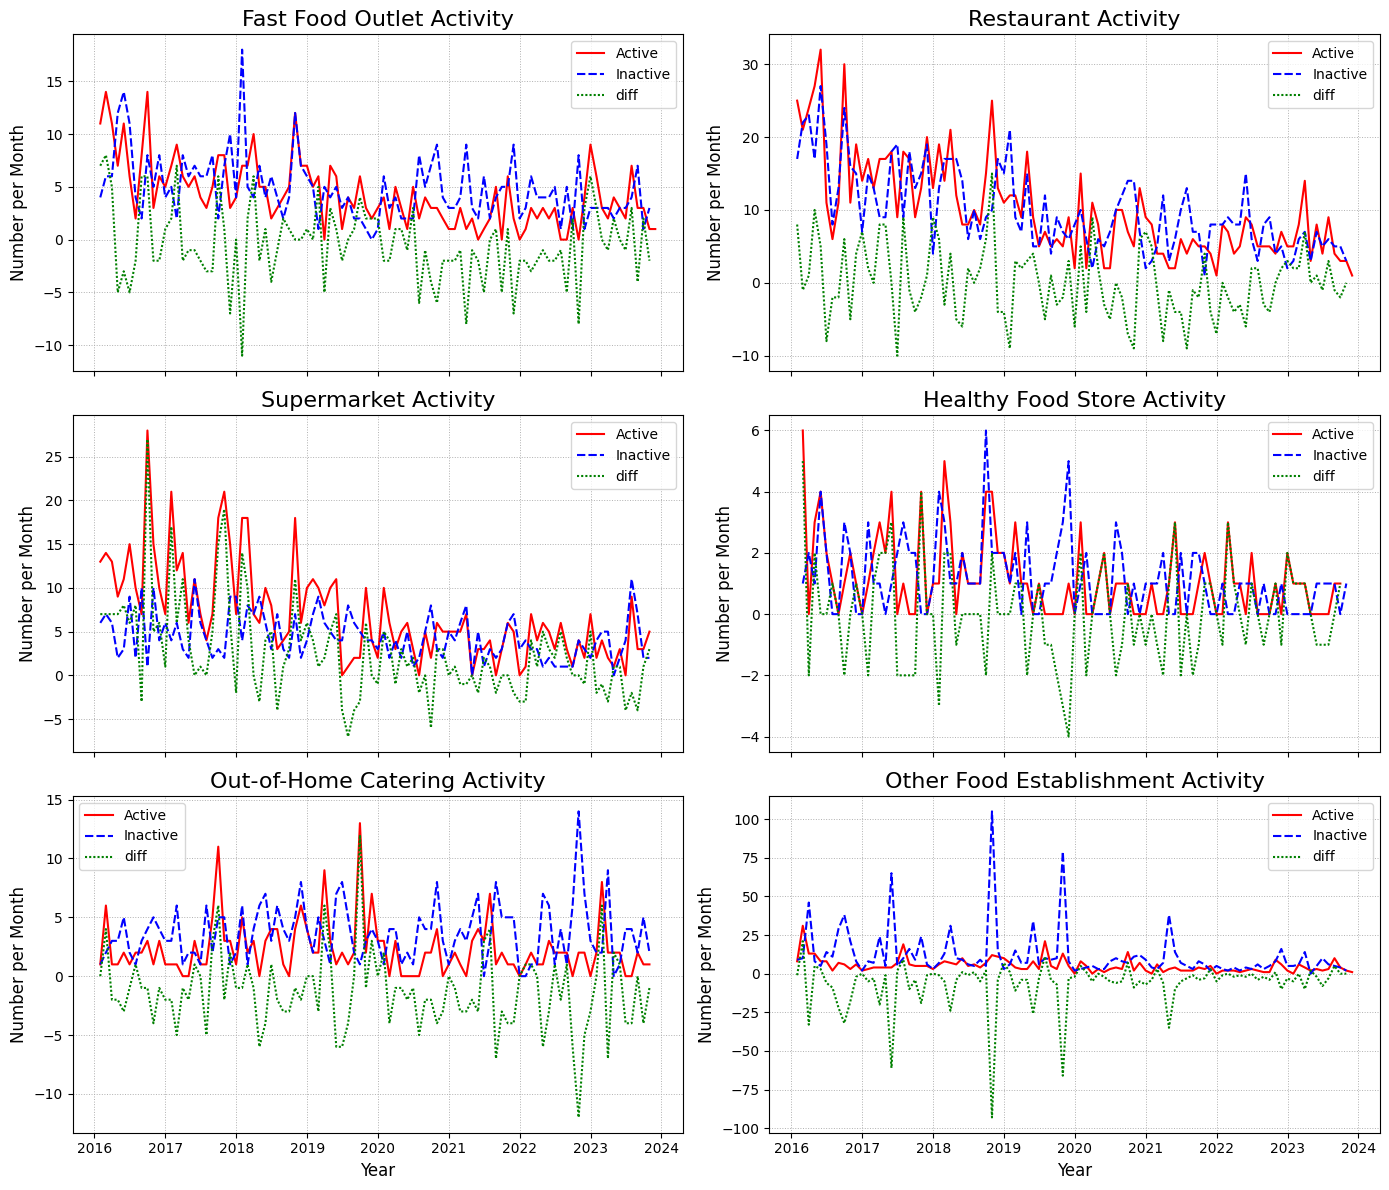

In [19]:
# --- Create 3x2 subplot grid ---
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)
axes = axes.ravel()

# Helper function for plotting cumulative data
def plot_time_series_data(ax, data, title, show_legend=False):
    sns.lineplot(
        ax=ax,
        data=data[['Active', 'Inactive', 'diff']],  # enforce order
        palette=['#FF0000', '#0000FF', '#008000']  # red=open, blue=closed
    )
    ax.set_title(title, size=16)
    ax.set_ylabel('Number per Month', size=12)
    ax.grid(True, linestyle=':', linewidth=0.7)

    # Show legend inside plot if requested
    if show_legend:
        ax.legend(loc='upper left', frameon=False)

# Plot each category
plot_time_series_data(axes[0], time_series_data_ff,       'Fast Food Outlet Activity')
plot_time_series_data(axes[1], time_series_data_rest,     'Restaurant Activity')
plot_time_series_data(axes[2], time_series_data_super,    'Supermarket Activity')
plot_time_series_data(axes[3], time_series_data_healthy,  'Healthy Food Store Activity')
plot_time_series_data(axes[4], time_series_data_catering, 'Out-of-Home Catering Activity')
plot_time_series_data(axes[5], time_series_data_other,    'Other Food Establishment Activity')

# Label x-axis only for the bottom row
for ax in axes[-2:]:
    ax.set_xlabel('Year', size=12)

plt.tight_layout()
output_path = os.path.join(output_folder, 'Food_Establishments_AllCategories.svg')
plt.savefig(output_path, format='svg', dpi=300)
plt.show()

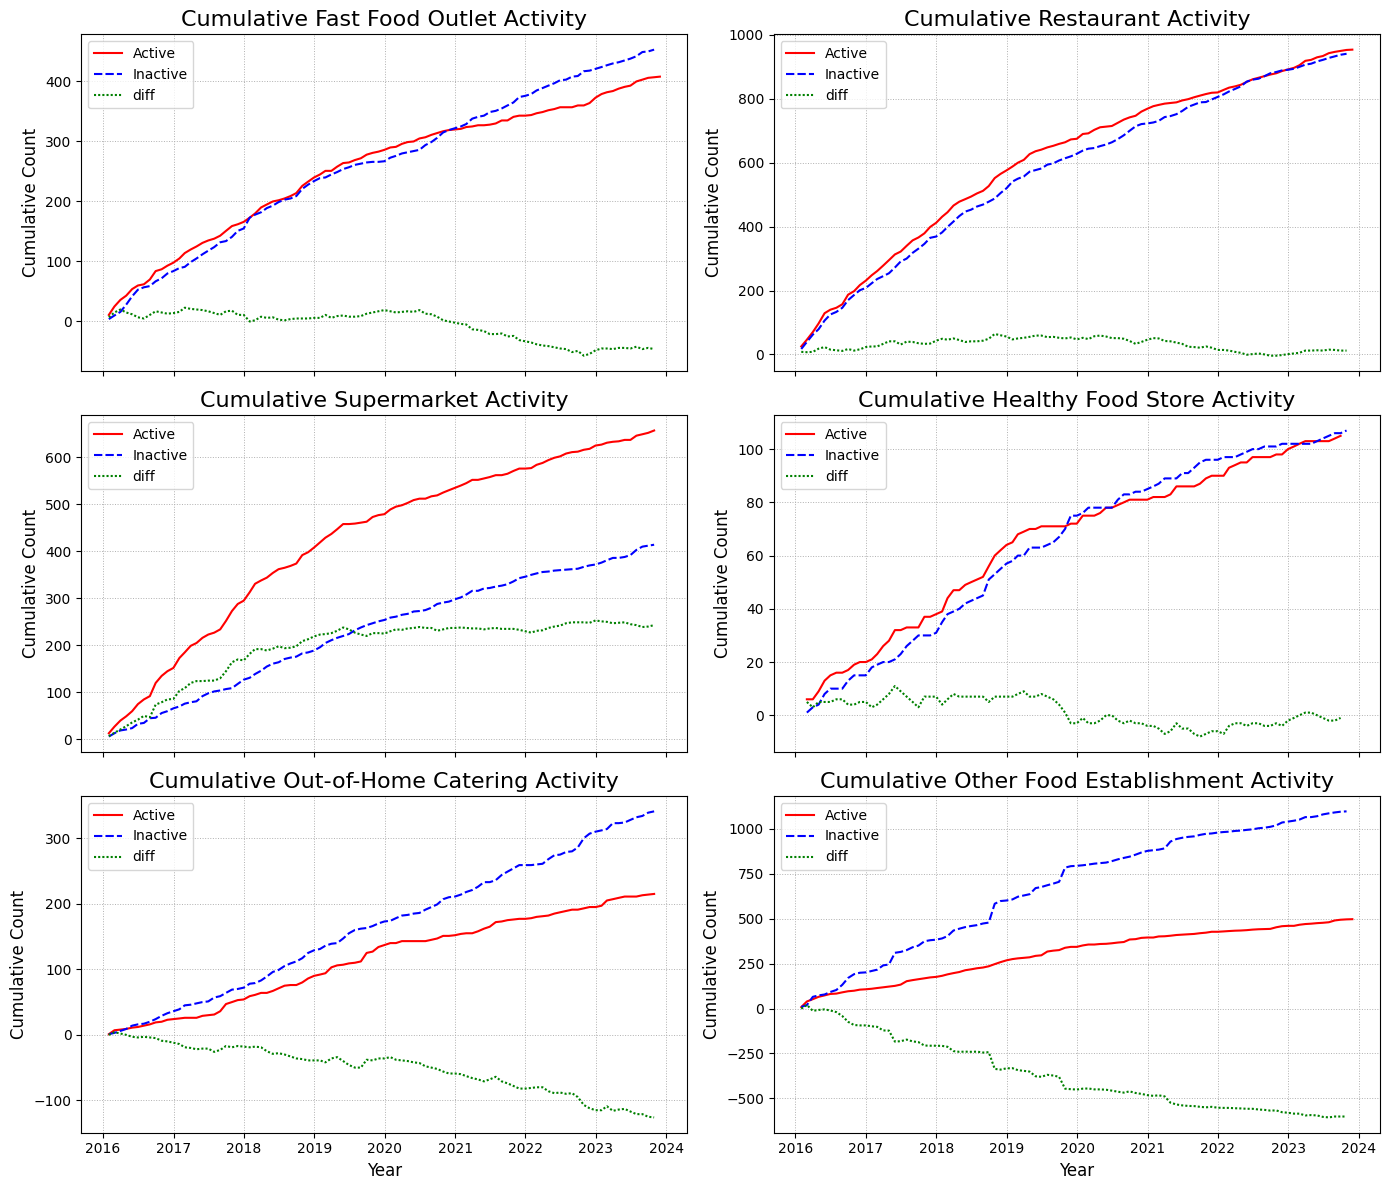

In [20]:
# --- Compute cumulative values for each category ---
cumulative_data_ff       = time_series_data_ff.cumsum()
cumulative_data_rest     = time_series_data_rest.cumsum()
cumulative_data_super    = time_series_data_super.cumsum()
cumulative_data_healthy  = time_series_data_healthy.cumsum()
cumulative_data_catering = time_series_data_catering.cumsum()
cumulative_data_other    = time_series_data_other.cumsum()

# --- Create 3x2 subplot grid ---
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)
axes = axes.ravel()

# Helper function for plotting cumulative data
def plot_cumulative(ax, data, title, show_legend=False):
    sns.lineplot(
        ax=ax,
        data=data[['Active', 'Inactive', 'diff']],  # enforce order
        palette=['#FF0000', '#0000FF', '#008000']  # red=open, blue=closed
    )
    ax.set_title(title, size=16)
    ax.set_ylabel('Cumulative Count', size=12)
    ax.grid(True, linestyle=':', linewidth=0.7)

    # Show legend inside plot if requested
    if show_legend:
        ax.legend(loc='upper left', frameon=False)

# Plot each category
plot_cumulative(axes[0], cumulative_data_ff,       'Cumulative Fast Food Outlet Activity')
plot_cumulative(axes[1], cumulative_data_rest,     'Cumulative Restaurant Activity')
plot_cumulative(axes[2], cumulative_data_super,    'Cumulative Supermarket Activity')
plot_cumulative(axes[3], cumulative_data_healthy,  'Cumulative Healthy Food Store Activity')
plot_cumulative(axes[4], cumulative_data_catering, 'Cumulative Out-of-Home Catering Activity')
plot_cumulative(axes[5], cumulative_data_other,    'Cumulative Other Food Establishment Activity')

# Label x-axis only for the bottom row
for ax in axes[-2:]:
    ax.set_xlabel('Year', size=12)

plt.tight_layout()
output_path = os.path.join(output_folder, 'Food_Establishments_AllCategories_CUMULATIVE.svg')
plt.savefig(output_path, format='svg', dpi=300)
plt.show()


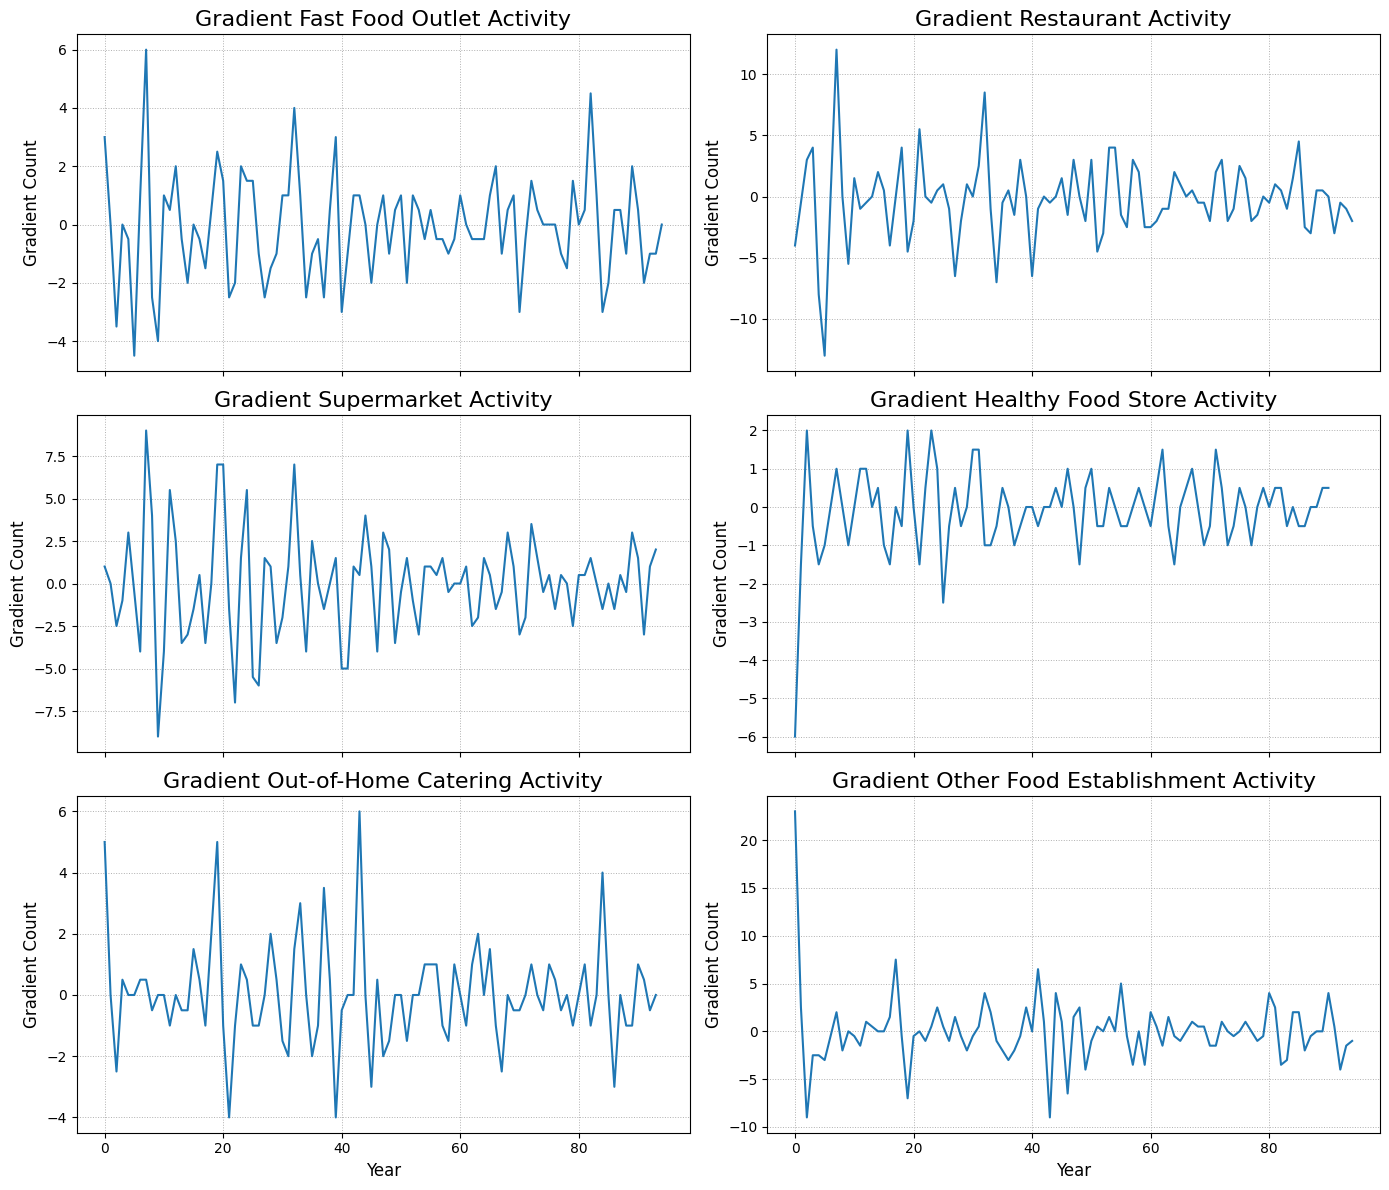

In [21]:
# --- Compute gradinet values for each category ---
gradient_ff       = np.gradient(time_series_data_ff['Active'].values)
gradient_rest     = np.gradient(time_series_data_rest['Active'].values)
gradient_super    = np.gradient(time_series_data_super['Active'].values)
gradient_healthy  = np.gradient(time_series_data_healthy['Active'].values)
gradient_catering = np.gradient(time_series_data_catering['Active'].values)
gradient_other    = np.gradient(time_series_data_other['Active'].values)

# --- Create 3x2 subplot grid ---
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)
axes = axes.ravel()

# Helper function for plotting cumulative data
def plot_gradient(ax, data, title, show_legend=False):
    sns.lineplot(
        ax=ax,
        data=data,  # enforce order
        palette=['#FF0000']  # red=open
    )
    ax.set_title(title, size=16)
    ax.set_ylabel('Gradient Count', size=12)
    ax.grid(True, linestyle=':', linewidth=0.7)

    # Show legend inside plot if requested
    if show_legend:
        ax.legend(loc='upper left', frameon=False)

# Plot each category
plot_gradient(axes[0], gradient_ff,       'Gradient Fast Food Outlet Activity')
plot_gradient(axes[1], gradient_rest,     'Gradient Restaurant Activity')
plot_gradient(axes[2], gradient_super,    'Gradient Supermarket Activity')
plot_gradient(axes[3], gradient_healthy,  'Gradient Healthy Food Store Activity')
plot_gradient(axes[4], gradient_catering, 'Gradient Out-of-Home Catering Activity')
plot_gradient(axes[5], gradient_other,    'Gradient Other Food Establishment Activity')

# Label x-axis only for the bottom row
for ax in axes[-2:]:
    ax.set_xlabel('Year', size=12)

plt.tight_layout()
output_path = os.path.join(output_folder, 'Food__Establishments_Gradient_Active_AllCategories.svg')
plt.savefig(output_path, format='svg', dpi=300)
plt.show()